In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import sklearn.model_selection as sk
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
labels_pd = pd.read_csv("/content/drive/MyDrive/BioE145_Final_Project/labels.csv")
counts_pd = pd.read_csv("/content/drive/MyDrive/BioE145_Final_Project/processed_counts.csv")
counts_pd = counts_pd.drop(columns=['Unnamed: 0'])

In [ ]:
print("labels", labels_pd)
print(counts_pd)

labels                 index      bulk_labels
0    AAAGCCTGGCTAAC-1   CD14+ Monocyte
1    AAATTCGATGCACA-1        Dendritic
2    AACACGTGGTCTTT-1         CD56+ NK
3    AAGTGCACGTGCTA-1  CD4+/CD25 T Reg
4    ACACGAACGGAGTG-1        Dendritic
..                ...              ...
695  TGGCACCTCCAACA-8        Dendritic
696  TGTGAGTGCTTTAC-8        Dendritic
697  TGTTACTGGCGATT-8  CD4+/CD25 T Reg
698  TTCAGTACCGGGAA-8          CD19+ B
699  TTGAGGTGGAGAGC-8        Dendritic

[700 rows x 2 columns]
      HES4  TNFRSF4  SSU72  PARK7   RBP7    SRM  MAD2L2  AGTRAP  TNFRSF1B  \
0   -0.326   -0.191 -0.728 -0.301  3.386 -0.531   2.016   3.377     4.841   
1    1.171   -0.191  0.795 -1.200 -0.174 -0.531   1.889  -0.486    -0.459   
2   -0.326   -0.191  0.483 -1.200 -0.174 -0.531  -0.451   0.971    -0.459   
3   -0.326   -0.191  1.134 -0.157 -0.174 -0.531  -0.451  -0.486    -0.459   
4   -0.326   -0.191 -0.728 -0.607 -0.174 -0.531  -0.451   0.787    -0.459   
..     ...      ...    ...    ...    ..

In [ ]:
X_train, X_test, Y_train, Y_test = sk.train_test_split(counts_pd, labels_pd, train_size=0.8, test_size=0.2, shuffle = True)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

# Define input shape
input_dim = 765  # Number of genes
latent_dim = 32  # Latent space dimension

# Define encoder model
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(1e-5))(encoded)

# Create the encoder model
encoder = Model(input_layer, encoded)

# Define decoder model
decoder_input = Input(shape=(latent_dim,))  # Input for the decoder
decoded = Dense(128, activation='relu')(decoder_input)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)  # Use 'linear' activation for output

# Create the decoder model
decoder = Model(decoder_input, decoded)

# Combine encoder and decoder into an autoencoder model
autoencoder_input = Input(shape=(input_dim,))
encoded_output = encoder(autoencoder_input)
decoded_output = decoder(encoded_output)
autoencoder = Model(autoencoder_input, decoded_output)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')  # Use 'mse' loss for regression

# Print summary of the model
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 765)]             0         
                                                                 
 model (Functional)          (None, 32)                233120    
                                                                 
 model_1 (Functional)        (None, 765)               233853    
                                                                 
Total params: 466973 (1.78 MB)
Trainable params: 466973 (1.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(counts_pd, labels_pd, test_size=0.2, shuffle=True)

# Define autoencoder architecture
input_dim = 765
latent_dim = 32

input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(1e-4))(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(1e-4))(encoded)
decoded = Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(1e-4))(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
cp = ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True)
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32,
                          validation_data=(X_test, X_test), callbacks=[es, cp])

# Evaluate the autoencoder on the test set
val_loss = autoencoder.evaluate(X_test, X_test)
print(f"Validation loss: {val_loss:.4f}")

# Retrain the model on all of the data
autoencoder.fit(counts_pd, counts_pd, epochs=50, batch_size=32)

test_loss = autoencoder.evaluate(X_test, X_test)
print(f"Test loss: {test_loss:.4f}")

Epoch 1/100
18/18 [==============================] - 2s 30ms/step - loss: 1.1133 - val_loss: 1.0385
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 1.0770

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 0s 16ms/step - loss: 1.0732 - val_loss: 1.0137
Epoch 3/100
18/18 [==============================] - 0s 16ms/step - loss: 1.0410 - val_loss: 0.9727
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 1.0016 - val_loss: 0.9417
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 0.9760 - val_loss: 0.9220
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 0.9591 - val_loss: 0.9101
Epoch 7/100
18/18 [==============================] - 0s 21ms/step - loss: 0.9483 - val_loss: 0.9010
Epoch 8/100
18/18 [==============================] - 0s 26ms/step - loss: 0.9399 - val_loss: 0.8949
Epoch 9/100
18/18 [==============================] - 0s 26ms/step - loss: 0.9329 - val_loss: 0.8886
Epoch 10/100
18/18 [==============================] - 0s 25ms/step - loss: 0.9252 - val_loss: 0.8825
Epoch 11/100
18/18 [==============================] - 0s 22ms/step - loss: 0.9189 - val_loss: 0.8777
Epoch 12/1

<ipython-input-16-ff5a13ea080e>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))


{'CD14+ Monocyte': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'Dendritic': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'CD56+ NK': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'CD4+/CD25 T Reg': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'CD19+ B': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), 'CD8+ Cytotoxic T': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 'CD4+/CD45RO+ Memory': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'CD8+/CD45RA+ Naive Cytotoxic': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), 'CD4+/CD45RA+/CD25- Naive T': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), 'CD34+': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)}


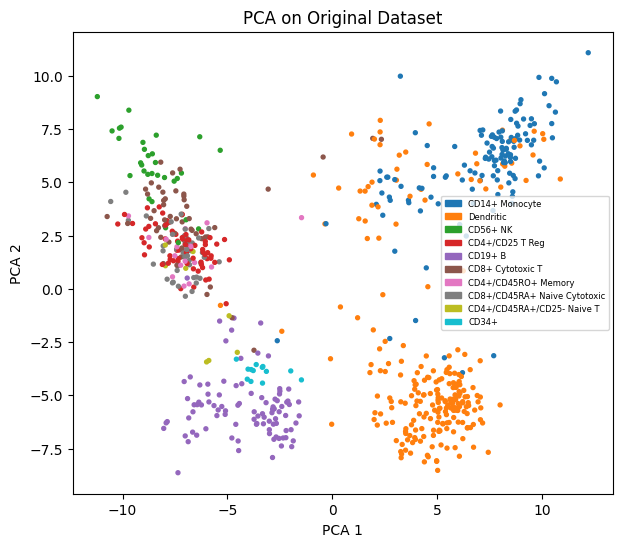

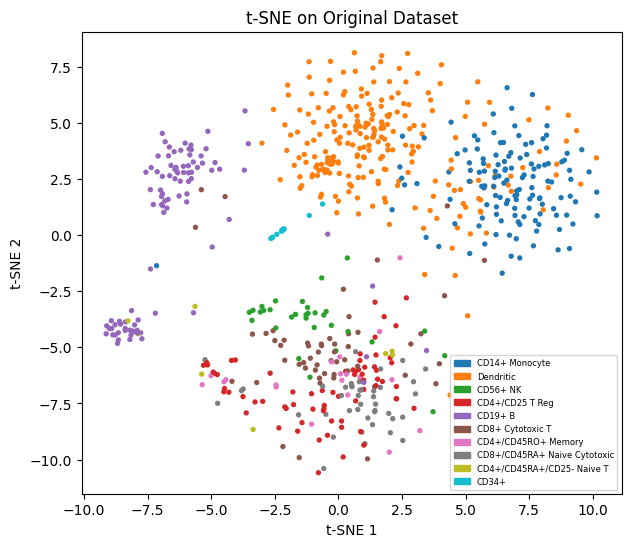

22/22 [==============================] - 0s 3ms/step


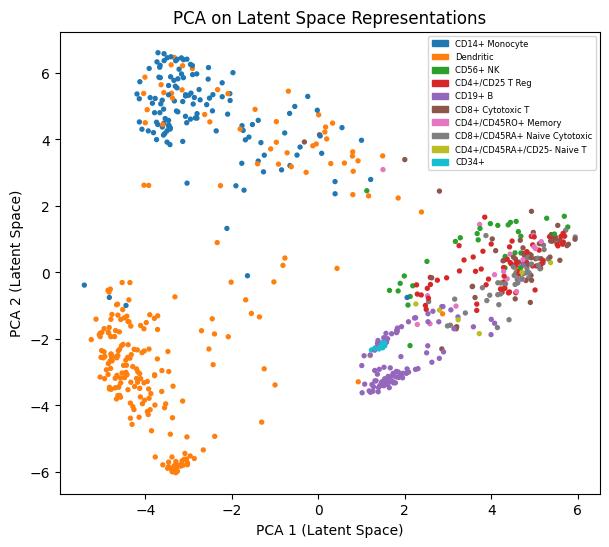

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Get unique labels from bulk_labels
unique_labels = labels_pd['bulk_labels'].unique()

# Create a colormap with 10 distinct colors
cmap = plt.cm.get_cmap('tab10', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]
legend_handles = [mpatches.Patch(color=cmap(i), label=label) for i, label in enumerate(unique_labels)]

y = labels_pd['bulk_labels'].values

label_to_color = dict(zip(unique_labels, colors))

print(label_to_color)

# Fit PCA on the original dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(counts_pd)

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[label_to_color[label] for label in y], s=8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA on Original Dataset')
plt.legend(handles=legend_handles, loc='best', fontsize=6)
plt.subplots_adjust(right=0.8)
plt.show()


# Fit t-SNE on the original dataset
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(counts_pd)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[label_to_color[label] for label in y], s=8)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE on Original Dataset')
plt.legend(handles=legend_handles, loc='best', fontsize=6)
plt.subplots_adjust(right=0.8)
plt.show()

latent_layer_index = -3  # Assuming the latent space layer is the 3rd last layer

# Get the encoder model
encoder = Model(autoencoder.input, autoencoder.layers[latent_layer_index].output)
X_latent = encoder.predict(counts_pd)

pca_latent = PCA(n_components=2)
X_latent_pca = pca_latent.fit_transform(X_latent)

# Plot the PCA results on the latent space
plt.figure(figsize=(8, 6))
plt.scatter(X_latent_pca[:, 0], X_latent_pca[:, 1], c=[label_to_color[label] for label in y], s=8)
plt.xlabel('PCA 1 (Latent Space)')
plt.ylabel('PCA 2 (Latent Space)')
plt.title('PCA on Latent Space Representations')
plt.legend(handles=legend_handles, loc='best', fontsize=6)
plt.subplots_adjust(right=0.8)
plt.show()